In [1]:
from bayes_opt import BayesianOptimization

In [19]:
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb

import pandas as pd
import numpy as np
import pickle
import time
import shap
import os
import gc

from sklearn.metrics import accuracy_score, recall_score, precision_score, precision_recall_curve
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, average_precision_score

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

import shap
shap.initjs()

from sm_utils import sampling, evaluate, save_model, load_model
from sm_utils import make_train_data,  make_test_data, df_to_md_table

In [3]:
DATA_PATH = '/home/dmig/work/dominic_workspace/data/'
MODEL_PATH = '/home/dmig/work/dominic_workspace/model/'

## load data

In [4]:
df_merge = pd.read_pickle(os.path.join(DATA_PATH, 'eqp_merge_le.pkl'))
df_meta = pd.read_pickle(os.path.join(DATA_PATH, 'eqp_meta.pkl'))

df_merge.shape, df_meta.shape

((1494418, 334), (1679, 15))

In [5]:
with open(os.path.join(DATA_PATH, 'eqp_le_dict.pkl'), 'rb') as f:
    le_dict = pickle.load(f)

In [6]:
df_merge['label_price_range'] = df_merge['label_out_prc'].apply(lambda x: 1600000 if x > 1600000 else x)
df_merge['label_price_range'] = pd.cut(df_merge['label_price_range'], bins=np.arange(0,1600001, 400000), labels=np.arange(0,4))

In [7]:
# feature
idx_col = 'svc_mgmt_num'
target_col = 'label_mfact_nm'
label_cols = [c for c in df_merge.columns if 'label_' in c]
# real_avg_arpu 값 이상함, 제거
feature_cols = [c for c in df_merge.columns if c not in [idx_col, 'ym', 'next_ym', 'real_avg_arpu', 'real_arpu_bf_m3'] + label_cols ]

In [8]:
# split data
df_trn = df_merge[df_merge['ym'].isin(['201904', '201905'])]
df_val = df_merge[df_merge['ym']=='201906']
df_tst = df_merge[df_merge['ym']=='201907']

In [20]:
# input
lgb_trn = lgb.Dataset(df_trn[feature_cols], df_trn[target_col], feature_name=feature_cols)
lgb_val = lgb.Dataset(df_val[feature_cols], df_val[target_col], feature_name=feature_cols)

In [21]:
def lgb_eval(num_leaves, feature_fraction, 
             lambda_l1, lambda_l2, is_unbalance):
    params = {
        'objective': 'multiclass',
        'num_class': df_merge[target_col].nunique(),
        'metric': 'multi_logloss',
        'boosting_type': 'gbdt',
        'learning_rate': 0.05,
        'num_threads': 30,
    }
    
    params['num_leaves'] = int(num_leaves)
    params['feature_fraction'] = feature_fraction
    params['lambda_l1'] = lambda_l1
    params['lambda_l2'] = lambda_l2
    params['is_unbalance'] = True if is_unbalance>0.5 else False
    
    print('num_leaves: ', num_leaves)
    print('feature_fraction: ', feature_fraction)
    print('lambda_l1: ', lambda_l1)
    print('lambda_l2: ', lambda_l2)
    print('is_unbalance: ', is_unbalance)
    
    t1 = time.time()
    clf = lgb.train(params,
                    train_set=lgb_trn,
                    valid_sets=[lgb_trn, lgb_val],
                    num_boost_round=3000,
                    early_stopping_rounds=50,
                    verbose_eval=100)
    t2 = time.time()
    print('train에 걸린 시간(초): ', t2-t1)
    
    # eval_metric: accuracy
    pred = clf.predict(df_tst[feature_cols], num_threads=30).argmax(axis=1)
    print('prediction에 걸린 시간(초): ', time.time()-t2)
    
    acc = accuracy_score(df_tst[target_col], pred)
    print('test acc: ', acc)
    return acc

In [22]:
target_params = {'num_leaves': (2, 128),
                 'feature_fraction': (0.5, 0.9),
                 'lambda_l1': (0, 100),
                 'lambda_l2': (0, 1000),
                 'is_unbalance': (0,1)
                }

In [23]:
lgbBO = BayesianOptimization(lgb_eval, target_params)

In [ ]:
lgbBO.maximize(init_points=10, n_iter=100)

## results

In [25]:
from pandas.io.json import json_normalize

df_params = json_normalize(pd.DataFrame(lgbBO.res)['params'])
df_res = pd.concat([df_params, pd.DataFrame(lgbBO.res)['target']], axis=1)

In [26]:
df_res.sort_values('target', ascending=False).head(20)

feature_fraction  is_unbalance  lambda_l1   lambda_l2  num_leaves  \
108          0.580093      0.077919  97.933894   19.366306  127.896098   
62           0.664779      0.681023  98.720196   12.807133  126.199455   
61           0.695562      0.950911  98.177441   15.194422  127.648207   
87           0.746981      0.443564  97.097342   17.318346  127.119527   
57           0.622044      0.275089  99.467483   12.636653  124.893132   
22           0.516574      0.597371  99.907676   13.054923  125.874015   
4            0.637197      0.675827  70.963197  641.392040   89.220717   
109          0.731896      0.167301  98.669148   34.004907  124.523748   
106          0.741585      0.054753  99.654954   32.145688  126.589486   
69           0.721326      0.620425  99.599573   45.736658  127.194947   
16           0.743228      0.974091  99.563562    8.472228  127.685009   
88           0.692664      0.695516  99.696957   23.591187  127.334619   
96           0.585326      0.022727  98.967232   20.063010  127.593651   
13           0.660852      0.325689  95.944105    0.982027  127.141129   
90           0.791158      0.071790  98.410344   61.302530  127.166486   
38           0.597495      0.504520   0.822133  988.475934  127.595081   
70           0.723224      0.316466  94.702083   23.420992  127.289424   
54           0.623573      0.536273  98.450812   13.591794  127.739516   
99           0.507670      0.153584  98.734607  954.724061  127.102937   
80           0.558187      0.155193  95.809978   24.055566  127.874612   

       target  
108  0.857986  
62   0.857929  
61   0.857852  
87   0.857819  
57   0.857805  
22   0.857787  
4    0.857784  
109  0.857748  
106  0.857739  
69   0.857721  
16   0.857710  
88   0.857701  
96   0.857689  
13   0.857689  
90   0.857662  
38   0.857656  
70   0.857656  
54   0.857653  
99   0.857650  
80   0.857644

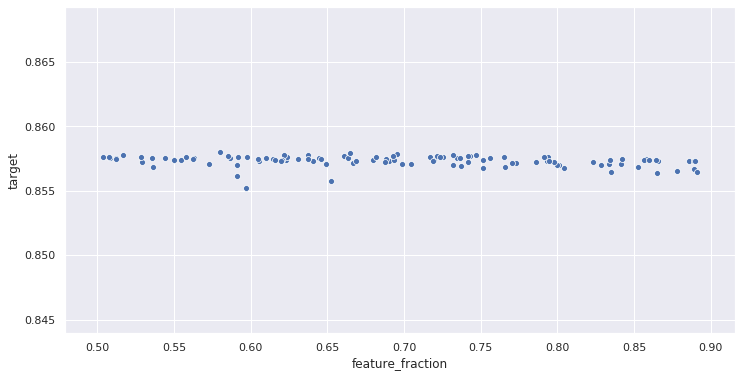

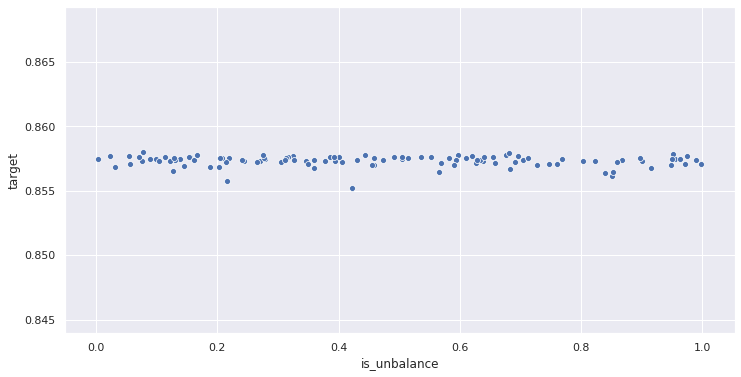

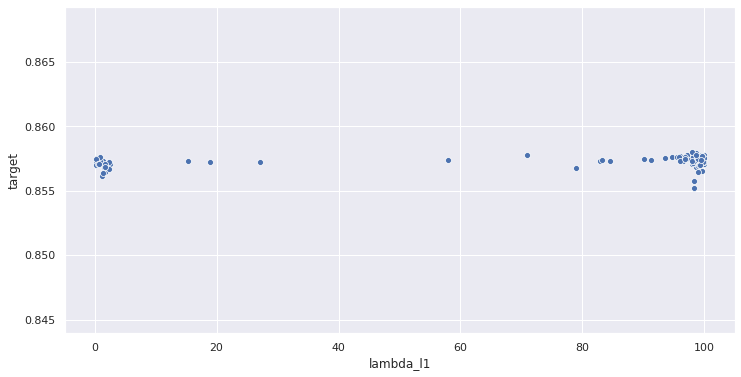

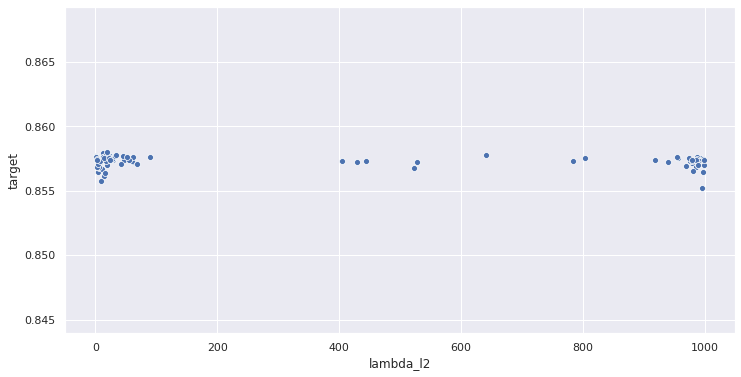

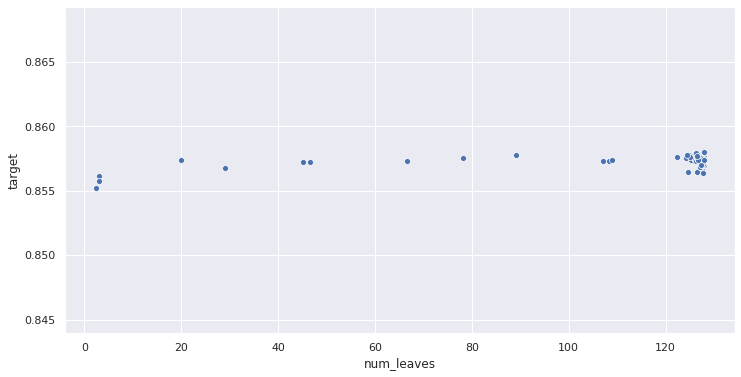

In [27]:
for col in df_params.columns:
    sns.set(rc={'figure.figsize': (12,6)})
    sns.scatterplot(df_res[col], df_res['target'])
    plt.show()